# AGRICULTURE - MODEL 2 - Simple lagged RF, no lat/long info

The goal hear is to have the simplest random forest using 1-year lag and all the variables constructed on the day 1. 

*I ignore the spatial aspect here to construct an example, will add soon*

## Initialise
### Imports

In [1]:
import time
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# impute NaN with the median of its country, to improve
class NUTSImputer(BaseEstimator, TransformerMixin):
    def __init__(self, nuts_id_column, strategy='mean'):
        self.nuts_id_column = nuts_id_column
        self.strategy = strategy
        self.impute_values = {}

    def fit(self, X, y=None):
        # Check if the NUTS_ID column exists
        if self.nuts_id_column not in X.columns:
            raise ValueError(f"{self.nuts_id_column} column not found in the DataFrame")

        # Compute imputation values for each group
        for nuts_id in X[self.nuts_id_column].unique():
            nuts_prefix = nuts_id[:2]
            filter_rows = X[self.nuts_id_column].str.startswith(nuts_prefix)

            if self.strategy == 'mean':
                self.impute_values[nuts_prefix] = X[filter_rows].mean()
            # Additional strategies can be implemented here

        return self

    def transform(self, X):
        # Ensure that X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        X_transformed = X.copy()
        for nuts_prefix, impute_value in self.impute_values.items():
            filter_rows = X[self.nuts_id_column].str.startswith(nuts_prefix)
            X_transformed.loc[filter_rows] = X_transformed[filter_rows].fillna(impute_value)

        return X_transformed

### Constants

In [3]:
ECON_DATA = "agr-v.csv"
CLIM_DATA = "final_dataset_reduced-v.csv"
CLIM_COLS = ["year", "NUTS_ID", 'hwi_sum','hwi_sum_lag','interacted_hwi_spi01','interacted_hwi_spi12','n_sma_lag','spi_01_max','spi_03_max','spi_06_max', 'SPI_12_max','tmax_mean']

TARGET = "A_Gva_perc"  # A for Agriculture, C for manufaCtoring 
# which columns to drop, e.g. here the other target variables, time, nuts name, and index
DROP_COLS = ["year", "NUTS_ID"]  

LAG_CLIM_COLS = ["n_sma", "hwi_sum"]  # which cols to lag
MIN_YEAR_TRAIN = 2003  # for ex. to eliminated lagged NA
MAX_YEAR_TRAIN = 2018
MIN_YEAR_VALID = 2019
MAX_YEAR_VALID = 2021

### Load dataset

In [4]:
econ_df = pd.read_csv(ECON_DATA, index_col=0)
econ_df

NUTS_ID  year  pop_perc  A_emp_perc  A_Gva_perc
0       AT111  2002       NaN         NaN         NaN
1       AT111  2003 -0.002120    0.000000    0.486486
2       AT111  2004 -0.001859   -0.062500   -0.181818
3       AT111  2005 -0.003459   -0.066667   -0.244444
4       AT111  2006  0.000000   -0.071429    0.088235
...       ...   ...       ...         ...         ...
26497   BE32C  2012       NaN    0.000000         NaN
26498   BE32D  2009       NaN    0.000000         NaN
26499   BE32D  2010       NaN   -0.100000         NaN
26500   BE32D  2011       NaN    0.000000         NaN
26501   BE32D  2012       NaN    0.000000         NaN

[26502 rows x 5 columns]

In [5]:
clim_df = pd.read_csv(CLIM_DATA, index_col=0)
# lag and filter
for lagcol in LAG_CLIM_COLS:
    clim_df[f"{lagcol}_lag"] = clim_df[lagcol].shift(1)
clim_df = clim_df[CLIM_COLS]
clim_df

year NUTS_ID    hwi_sum  hwi_sum_lag  interacted_hwi_spi01  \
0      2002   AT111  17.450511          NaN             27.912092   
1      2003   AT111  10.337299    17.450511              6.621040   
2      2004   AT111   5.598158    10.337299              8.912268   
3      2005   AT111   1.529521     5.598158              2.211688   
4      2006   AT111   9.340811     1.529521             15.118102   
...     ...     ...        ...          ...                   ...   
25300  2017   SK042   6.603099     5.616843             10.733337   
25301  2018   SK042   5.230994     6.603099              5.484697   
25302  2019   SK042  45.962998     5.230994             72.276814   
25303  2020   SK042        NaN    45.962998                   NaN   
25304  2021   SK042  10.214574          NaN                   NaN   

       interacted_hwi_spi12  n_sma_lag  spi_01_max  spi_03_max  spi_06_max  \
0                  5.505636        NaN      1.5995      1.4325      1.1380   
1                  7.034532        7.0      0.6405      0.6860      1.6705   
2                  1.978949        1.0      1.5920      1.4985      1.6150   
3                  0.984247        0.0      1.4460      1.3905      1.2395   
4                 15.244203        0.0      1.6185      1.2760      1.2195   
...                     ...        ...         ...         ...         ...   
25300              4.889595        0.0      1.6255      1.3440      1.1425   
25301              6.033951        0.0      1.0485      1.3115      2.0210   
25302              1.057149        2.0      1.5725      1.1630      0.5785   
25303                   NaN        4.0      1.8240      1.5540      1.7855   
25304                   NaN        0.0         NaN         NaN         NaN   

       SPI_12_max  tmax_mean  
0          0.3155  14.163750  
1          0.6805  14.362667  
2          0.3535  13.233500  
3          0.6435  12.495500  
4          1.6320  13.789333  
...           ...        ...  
25300      0.7405  13.794917  
25301      1.1535  14.035000  
25302      0.0230  14.798000  
25303      1.6385  14.123833  
25304         NaN        NaN  

[22420 rows x 12 columns]

In [6]:
in_df = pd.merge(econ_df, clim_df, on=['year', 'NUTS_ID'])

#### Basic Exploratory Analysis, to show / complete as needed

In [7]:
print(f"Data shape:\n{in_df.shape}\n")
# print(f"Data Types:\n{in_df.dtypes}\n")
# print(f"Data Range:\n{in_df.describe()}\n")

Data shape:
(22420, 15)



#### Explore missing values

In [8]:
miss_val_in_col = in_df.isna().sum()
miss_val_in_col = miss_val_in_col[miss_val_in_col > 0].sort_values()
frac_miss_val = miss_val_in_col / in_df.shape[0]
miss_df = pd.DataFrame({'Counts of Missing': miss_val_in_col, 'Fractions of Missing': frac_miss_val})
print(f"Missing value counts and fractions by column:\n{miss_df}\n")
print(f"Rows with missing values\n")
in_df[in_df.isna().any(axis=1)]

Missing value counts and fractions by column:
                      Counts of Missing  Fractions of Missing
n_sma_lag                             1              0.000045
spi_06_max                          453              0.020205
spi_03_max                          453              0.020205
spi_01_max                          453              0.020205
SPI_12_max                          453              0.020205
pop_perc                           1299              0.057939
A_Gva_perc                         1334              0.059500
A_emp_perc                         1993              0.088894
tmax_mean                          3029              0.135103
hwi_sum                            5802              0.258787
hwi_sum_lag                        5803              0.258831
interacted_hwi_spi01               6036              0.269224
interacted_hwi_spi12               6036              0.269224

Rows with missing values



NUTS_ID  year  pop_perc  A_emp_perc  A_Gva_perc    hwi_sum  hwi_sum_lag  \
0       AT111  2002       NaN         NaN         NaN  17.450511          NaN   
18      AT111  2020 -0.001068    0.000000    0.189189        NaN    49.921879   
19      AT112  2002       NaN         NaN         NaN   7.855846          NaN   
37      AT112  2020  0.007524    0.023256    0.117647        NaN    56.059412   
38      AT113  2002       NaN         NaN         NaN  17.673482          NaN   
...       ...   ...       ...         ...         ...        ...          ...   
22407   SK042  2009  0.002763   -0.011224   -0.271719        NaN     2.493420   
22408   SK042  2010  0.003077    0.006192   -0.195374        NaN          NaN   
22409   SK042  2011  0.016391   -0.032821    0.247324   1.722158          NaN   
22418   SK042  2020  0.001336   -0.056893   -0.060141        NaN    45.962998   
22419   SK042  2021 -0.025843         NaN    0.132985  10.214574          NaN   

       interacted_hwi_spi01  interacted_hwi_spi12  n_sma_lag  spi_01_max  \
0                 27.912092              5.505636        NaN      1.5995   
18                      NaN                   NaN        1.0      1.2230   
19                12.891443              4.473904        1.0      1.6410   
37                      NaN                   NaN        1.0      1.4555   
38                22.834138              1.290164        2.0      1.2920   
...                     ...                   ...        ...         ...   
22407                   NaN                   NaN        0.0      1.2660   
22408                   NaN                   NaN        0.0      2.8445   
22409              2.359356              4.632604        0.0      1.3700   
22418                   NaN                   NaN        4.0      1.8240   
22419                   NaN                   NaN        0.0         NaN   

       spi_03_max  spi_06_max  SPI_12_max  tmax_mean  
0          1.4325      1.1380      0.3155  14.163750  
18         1.2935      1.0350      0.4890  15.041833  
19         1.5835      1.4125      0.5695  15.782500  
37         1.2400      1.2400      0.7210  16.631417  
38         1.1150      0.8620      0.0730  15.055667  
...           ...         ...         ...        ...  
22407      1.8860      0.4880      0.7440  13.705083  
22408      2.8410      2.6880      3.0600  12.368833  
22409      1.2225      1.0385      2.6900  13.783333  
22418      1.5540      1.7855      1.6385  14.123833  
22419         NaN         NaN         NaN        NaN  

[11058 rows x 15 columns]

In [9]:
print(f"Missing value counts by column:\n{in_df.isnull().sum()}\n")
print(f"Rows with missing values\n")
in_df[in_df.isna().any(axis=1)]

Missing value counts by column:
NUTS_ID                    0
year                       0
pop_perc                1299
A_emp_perc              1993
A_Gva_perc              1334
hwi_sum                 5802
hwi_sum_lag             5803
interacted_hwi_spi01    6036
interacted_hwi_spi12    6036
n_sma_lag                  1
spi_01_max               453
spi_03_max               453
spi_06_max               453
SPI_12_max               453
tmax_mean               3029
dtype: int64

Rows with missing values



NUTS_ID  year  pop_perc  A_emp_perc  A_Gva_perc    hwi_sum  hwi_sum_lag  \
0       AT111  2002       NaN         NaN         NaN  17.450511          NaN   
18      AT111  2020 -0.001068    0.000000    0.189189        NaN    49.921879   
19      AT112  2002       NaN         NaN         NaN   7.855846          NaN   
37      AT112  2020  0.007524    0.023256    0.117647        NaN    56.059412   
38      AT113  2002       NaN         NaN         NaN  17.673482          NaN   
...       ...   ...       ...         ...         ...        ...          ...   
22407   SK042  2009  0.002763   -0.011224   -0.271719        NaN     2.493420   
22408   SK042  2010  0.003077    0.006192   -0.195374        NaN          NaN   
22409   SK042  2011  0.016391   -0.032821    0.247324   1.722158          NaN   
22418   SK042  2020  0.001336   -0.056893   -0.060141        NaN    45.962998   
22419   SK042  2021 -0.025843         NaN    0.132985  10.214574          NaN   

       interacted_hwi_spi01  interacted_hwi_spi12  n_sma_lag  spi_01_max  \
0                 27.912092              5.505636        NaN      1.5995   
18                      NaN                   NaN        1.0      1.2230   
19                12.891443              4.473904        1.0      1.6410   
37                      NaN                   NaN        1.0      1.4555   
38                22.834138              1.290164        2.0      1.2920   
...                     ...                   ...        ...         ...   
22407                   NaN                   NaN        0.0      1.2660   
22408                   NaN                   NaN        0.0      2.8445   
22409              2.359356              4.632604        0.0      1.3700   
22418                   NaN                   NaN        4.0      1.8240   
22419                   NaN                   NaN        0.0         NaN   

       spi_03_max  spi_06_max  SPI_12_max  tmax_mean  
0          1.4325      1.1380      0.3155  14.163750  
18         1.2935      1.0350      0.4890  15.041833  
19         1.5835      1.4125      0.5695  15.782500  
37         1.2400      1.2400      0.7210  16.631417  
38         1.1150      0.8620      0.0730  15.055667  
...           ...         ...         ...        ...  
22407      1.8860      0.4880      0.7440  13.705083  
22408      2.8410      2.6880      3.0600  12.368833  
22409      1.2225      1.0385      2.6900  13.783333  
22418      1.5540      1.7855      1.6385  14.123833  
22419         NaN         NaN         NaN        NaN  

[11058 rows x 15 columns]

### Transform dataset
put your futher transforms like cleanup or normalisation here...

#### Filter by years

In [10]:
df = in_df[ (in_df.year>=MIN_YEAR_TRAIN) & (in_df.year<=MAX_YEAR_TRAIN) ]
df_valid = in_df[ (in_df.year>=MIN_YEAR_VALID) & (in_df.year<=MAX_YEAR_VALID) ]

#### Impute missing values

In [11]:
# filling in with zeros, FOR TESTING ONLY
# df = df.fillna(0)
# df_valid = df_valid.fillna(0)
# drop nans
# df = df.dropna()
# df_valid = df_valid.dropna() 

# impute country median if not known
imputer = NUTSImputer(nuts_id_column='NUTS_ID', strategy='median')
imputer.fit(df)
df = imputer.transform(df)
df = df.dropna()

imputer = NUTSImputer(nuts_id_column='NUTS_ID', strategy='median')
imputer.fit(df_valid)
df_valid = imputer.transform(df_valid)
df_valid = df_valid.dropna()

#### Impute infinite values

In [12]:
df = df.replace([np.inf, -np.inf], 0)
df_valid = df_valid.replace([np.inf, -np.inf], 0)

#### Normalise

In [13]:
calculation_years = df['year'].copy()  # Use copy to avoid SettingWithCopyWarning
calculation_nuts = df['NUTS_ID'].copy()
# Drop 'NUTS_ID' for scaling
df = df.drop("NUTS_ID", axis=1)
# Initialize and apply MinMaxScaler
scaler_train = MinMaxScaler()
scaled_df = scaler_train.fit_transform(df)
# Create a new DataFrame from scaled data and reassign 'year' and 'NUTS_ID'
df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
df['year'] = calculation_years
df['NUTS_ID'] = calculation_nuts

In [14]:
calculation_years = df_valid['year'].copy()  # Use copy to avoid SettingWithCopyWarning
calculation_nuts = df_valid['NUTS_ID'].copy()
# Drop 'NUTS_ID' for scaling
df_valid = df_valid.drop("NUTS_ID", axis=1)
# Initialize and apply MinMaxScaler
scaled_df = scaler_train.fit_transform(df_valid)
# Create a new DataFrame from scaled data and reassign 'year' and 'NUTS_ID'
df_valid = pd.DataFrame(scaled_df, columns=df_valid.columns, index=df_valid.index)
df_valid['year'] = calculation_years
df_valid['NUTS_ID'] = calculation_nuts
df_valid

year  pop_perc  A_emp_perc  A_Gva_perc   hwi_sum  hwi_sum_lag  \
17     2019  0.590451    0.435583    0.200948  0.704559     0.030130   
36     2019  0.665481    0.410265    0.143951  0.791348     0.049852   
56     2020  0.617846    0.435583    0.285185  0.027504     0.533322   
74     2019  0.633750    0.370817    0.255673  0.230798     0.110463   
75     2020  0.627918    0.463089    0.282001  0.065093     0.383774   
...     ...       ...         ...         ...       ...          ...   
22358  2020  0.614164    0.392117    0.506786  0.050288     0.552278   
22377  2019  0.583522    0.430109    0.140918  0.299963     0.120254   
22378  2020  0.589678    0.430082    0.258200  0.050651     0.499776   
22397  2019  0.623806    0.428707    0.155360  0.911424     0.234273   
22417  2019  0.622749    0.470788    0.145879  0.648577     0.118439   

       interacted_hwi_spi01  interacted_hwi_spi12  n_sma_lag  spi_01_max  \
17                 0.450949              0.374407   0.000000    0.278395   
36                 0.596812              0.273203   0.083333    0.330577   
56                 0.018170              0.279816   0.333333    0.297371   
74                 0.222788              0.385790   0.583333    0.427487   
75                 0.049833              0.294259   0.583333    0.338845   
...                     ...                   ...        ...         ...   
22358              0.058157              0.323737   0.083333    0.514231   
22377              0.295228              0.337695   0.166667    0.436026   
22378              0.069636              0.333694   0.000000    0.611683   
22397              0.916567              0.766339   0.250000    0.445649   
22417              0.602807              0.274391   0.166667    0.410816   

       spi_03_max  spi_06_max  SPI_12_max  tmax_mean NUTS_ID  
17       0.303847    0.346645    0.363867   0.526869   AT111  
36       0.468179    0.473718    0.306141   0.591731   AT112  
56       0.574012    0.594795    0.508247   0.518918   AT113  
74       0.934232    0.807604    0.509769   0.528438   AT121  
75       0.521893    0.629497    0.478305   0.512778   AT121  
...           ...         ...         ...        ...     ...  
22358    0.792058    0.762567    0.756534   0.379467   SK031  
22377    0.487502    0.460577    0.398376   0.480106   SK032  
22378    0.782131    0.893723    0.829739   0.448789   SK032  
22397    0.493884    0.635621    0.521188   0.454549   SK041  
22417    0.514093    0.441056    0.307790   0.489583   SK042  

[1413 rows x 15 columns]

## Fit / Crossvalidate

### Data splits

In [15]:
# Define the features and target
X = df.drop(TARGET, axis=1).drop(DROP_COLS, axis=1)
y = df[TARGET]

# Define KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# Initialise the results
results = []

### Hyperparameters

In [16]:
# Define different hyperparameters for RandomForestRegressor
RF_hyperparams = []

n_estimators_values = [100, 200]
max_samples_values = [0.5, 0.75, 1.0]
max_features_values = [0.5, 0.75, 1.0]

for n_estimators in n_estimators_values:
    for max_samples in max_samples_values:
        for max_features in max_features_values:
            RF_hyperparams.append({
                'n_estimators': n_estimators,
                'max_samples': max_samples,
                'max_features': max_features
            })

RF_hyperparams_test = [
    {'n_estimators': 50, 'max_depth': 10},
    {'n_estimators': 50, 'max_depth': 20},
    {'n_estimators': 50, 'max_depth': 30},
]

RF_hyperparams

[{'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.5},
 {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.75},
 {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0},
 {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.5},
 {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.75},
 {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 1.0},
 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.5},
 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.75},
 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0},
 {'n_estimators': 200, 'max_samples': 0.5, 'max_features': 0.5},
 {'n_estimators': 200, 'max_samples': 0.5, 'max_features': 0.75},
 {'n_estimators': 200, 'max_samples': 0.5, 'max_features': 1.0},
 {'n_estimators': 200, 'max_samples': 0.75, 'max_features': 0.5},
 {'n_estimators': 200, 'max_samples': 0.75, 'max_features': 0.75},
 {'n_estimators': 200, 'max_samples': 0.75, 'max_features': 1.0},
 {'n_estimator

### Cross-validation (for each set of hyperparameters)

In [17]:
for params in RF_hyperparams:
    start_time = time.time()
    print(f"Starting {params} at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())} GMT\n")
    model = RandomForestRegressor(**params, random_state=4)
    mse = cross_val_score(model, 
                          X, 
                          y, 
                          cv=kf, 
                          scoring=make_scorer(mean_squared_error),
                          error_score='raise')
    results.append({'Model': 'RandomForestRegressor', 
                    'Hyperparameters': params, 
                    'MSE': np.mean(mse)})
    elapsed_time = time.time() - start_time
    print(f"Ended {params} in {elapsed_time:.2f} s.\n")
    
# Store results
results_df = pd.DataFrame(results)
results_df

Starting {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.5} at 2023-11-15 15:25:14 GMT

Ended {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.5} in 19.52 s.

Starting {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.75} at 2023-11-15 15:25:34 GMT

Ended {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.75} in 28.54 s.

Starting {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0} at 2023-11-15 15:26:02 GMT

Ended {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0} in 38.28 s.

Starting {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.5} at 2023-11-15 15:26:41 GMT

Ended {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.5} in 27.68 s.

Starting {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.75} at 2023-11-15 15:27:08 GMT

Ended {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.75} in 40.36 s.

Starting {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 1.0} at 2023-1

Model                                    Hyperparameters  \
0   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.5, 'max...   
1   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.5, 'max...   
2   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.5, 'max...   
3   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.75, 'ma...   
4   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.75, 'ma...   
5   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.75, 'ma...   
6   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 1.0, 'max...   
7   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 1.0, 'max...   
8   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 1.0, 'max...   
9   RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.5, 'max...   
10  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.5, 'max...   
11  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.5, 'max...   
12  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.75, 'ma...   
13  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.75, 'ma...   
14  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.75, 'ma...   
15  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 1.0, 'max...   
16  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 1.0, 'max...   
17  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 1.0, 'max...   

         MSE  
0   0.000171  
1   0.000171  
2   0.000175  
3   0.000173  
4   0.000172  
5   0.000175  
6   0.000173  
7   0.000179  
8   0.000177  
9   0.000169  
10  0.000170  
11  0.000172  
12  0.000170  
13  0.000173  
14  0.000173  
15  0.000170  
16  0.000174  
17  0.000175

### Model selection (based on Mean Square Error)

In [18]:
best_model_params = results_df.sort_values('MSE').iloc[0]['Hyperparameters']
best_model = RandomForestRegressor(**best_model_params, random_state=4) 
best_model

RandomForestRegressor(max_features=0.5, max_samples=0.5, n_estimators=200,
                      random_state=4)

## Explicability

In [19]:
# Train the best model on the entire dataset
X = df.drop(TARGET, axis=1).drop(DROP_COLS, axis=1)
y = df[TARGET]
best_model.fit(X, y)

# Get feature importances
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance.sort_values('Importance', ascending=False)

Feature  Importance
0               pop_perc    0.154715
8             spi_03_max    0.141300
11             tmax_mean    0.105598
7             spi_01_max    0.102452
3            hwi_sum_lag    0.079847
5   interacted_hwi_spi12    0.074981
9             spi_06_max    0.074371
1             A_emp_perc    0.068345
10            SPI_12_max    0.063280
2                hwi_sum    0.063104
4   interacted_hwi_spi01    0.049994
6              n_sma_lag    0.022014

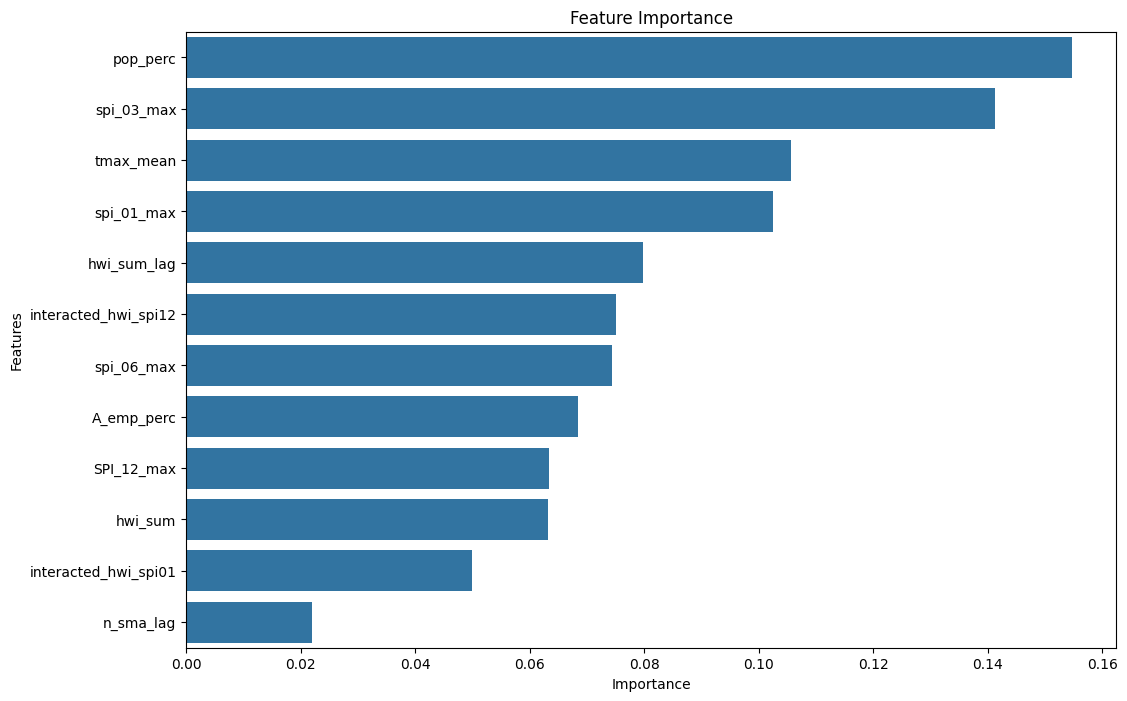

In [20]:
# Sort features according to importance
TOP_N = 20
feature_importance = feature_importance.sort_values('Importance', ascending=False)[:TOP_N]

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Validation (is all we need)

In [22]:
# Define the features and target
X_valid = df_valid.drop(TARGET, axis=1).drop(DROP_COLS, axis=1)
y_pred = best_model.predict(X_valid)

In [35]:
dfGva = pd.read_csv("dfGva.csv", index_col=0)
dfGva = dfGva[ (dfGva.year>=MIN_YEAR_TRAIN) & (dfGva.year<=MAX_YEAR_VALID) ]
dfGva

NUTS_ID  year   A_Gva  B-E_Gva    C_Gva  G-J_Gva  Gva_Energ  A_Gva_lag  \
1       AT111  2003   55.00   129.00    95.00   117.00      34.00      37.00   
2       AT111  2004   45.00   119.00    92.00   116.00      27.00      55.00   
3       AT111  2005   34.00   136.00   110.00   113.00      26.00      45.00   
4       AT111  2006   37.00   136.00   111.00   123.00      25.00      34.00   
5       AT111  2007   47.00   137.00   112.00   129.00      25.00      37.00   
...       ...   ...     ...      ...      ...      ...        ...        ...   
22441   SK042  2017  216.82  2350.20  2258.92  2444.02      91.28     194.54   
22442   SK042  2018  235.71  2597.97  2486.22  2458.81     111.75     216.82   
22443   SK042  2019  195.54  2651.68  2546.43  2642.94     105.25     235.71   
22444   SK042  2020  183.78  2463.48  2337.87  2663.64     125.61     195.54   
22445   SK042  2021  208.22  2958.89  2835.63  2861.08     123.26     183.78   

       A_Gva_perc  C_Gva_lag  C_Gva_perc  G-J_Gva_lag  G-J_Gva_perc  \
1        0.486486      92.00    0.032609       106.00      0.103774   
2       -0.181818      95.00   -0.031579       117.00     -0.008547   
3       -0.244444      92.00    0.195652       116.00     -0.025862   
4        0.088235     110.00    0.009091       113.00      0.088496   
5        0.270270     111.00    0.009009       123.00      0.048780   
...           ...        ...         ...          ...           ...   
22441    0.114527    2237.65    0.009506      2217.20      0.102300   
22442    0.087123    2258.92    0.100623      2444.02      0.006052   
22443   -0.170421    2486.22    0.024217      2458.81      0.074886   
22444   -0.060141    2546.43   -0.081903      2642.94      0.007832   
22445    0.132985    2337.87    0.212912      2663.64      0.074124   

       B-E_Gva_lag  B-E_Gva_perc  Gva_Energ_lag  Gva_Energ_perc  
1           117.00      0.102564          25.00        0.360000  
2           129.00     -0.077519          34.00       -0.205882  
3           119.00      0.142857          27.00       -0.037037  
4           136.00      0.000000          26.00       -0.038462  
5           136.00      0.007353          25.00        0.000000  
...            ...           ...            ...             ...  
22441      2335.41      0.006333          97.76       -0.066285  
22442      2350.20      0.105425          91.28        0.224255  
22443      2597.97      0.020674         111.75       -0.058166  
22444      2651.68     -0.070974         105.25        0.193444  
22445      2463.48      0.201102         125.61       -0.018709  

[21315 rows x 17 columns]

In [36]:
def return_gva(model, x_test, x_test_final, dfGva, segment):
    y_predict = model.predict(x_test)
    df_y_predict = pd.DataFrame(y_predict)
    df_y_predict.rename(columns = {0: "y_predict"}, inplace = True)
    x_test_return = pd.DataFrame(x_test)
    df = df_y_predict.merge(x_test_final, left_index = True, right_index = True)
    df = df.merge(x_test_final, left_index = True, right_index = True , how = 'outer')
    df = df.merge(dfGva, left_index = True, right_index = True , how = 'outer')
    df["Final_Prediction"] = df[segment+'_Gva_lag']*df['y_predict']+df[segment+'_Gva_lag']
    df = df[["NUTS_ID", 'Final_Prediction',"year"]]
    return df

In [45]:
result_gva = return_gva(best_model, X, X_valid, dfGva, "A")
result_gva = result_gva[ (result_gva.year>=MIN_YEAR_VALID) & (result_gva.year<=MAX_YEAR_VALID) ]

NUTS_ID  Final_Prediction  year
17      AT111         45.743312  2019
18      AT111               NaN  2020
36      AT112        204.737756  2019
37      AT112               NaN  2020
55      AT113               NaN  2019
...       ...               ...   ...
22424   SK041               NaN  2020
22425   SK041               NaN  2021
22443   SK042               NaN  2019
22444   SK042               NaN  2020
22445   SK042               NaN  2021

[2595 rows x 3 columns]

In [47]:
result = pd.DataFrame({'year': calculation_years, 'NUTS_ID': calculation_nuts, "Agr": result_gva.Final_Prediction})
result.to_csv("result_agriculture.csv")